## pret-raind ( using InceptionV3)

In [1]:
from keras.applications.inception_v3 import InceptionV3

Using TensorFlow backend.


In [2]:
model = InceptionV3(include_top=False, weights='imagenet')  # 出力層側にある全結合層は使用しない
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [3]:
import pandas as pd
data_df = pd.read_csv('../outputs/target_idx.csv')
data_df.head()

,Image Index,Emphysema
0,00000009_000.png,1
1,00000013_041.png,1
2,00000013_042.png,1
3,00000027_000.png,1
4,00000034_000.png,1


In [4]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1. / 255.)

img_dir = "../inputs/images/"

generator = datagen.flow_from_dataframe(
                            dataframe=data_df,
                            directory=img_dir,
                            x_col="Image Index",
                            y_col="Emphysema",
                            has_ext=True,                                      
                            subset="training",
                            batch_size=32,
                            seed=1,
                            shuffle=False,
                            color_mode = 'rgb',
                            class_mode="binary",
                            target_size=(512, 512))

Found 1892 images belonging to 2 classes.


### NIH Datasetを入力とし、InceptionV3のbottleneck_featuresを出力

In [5]:
%%time
train_samples = len(data_df.index)
# bottleneck_features_train = model.predict_generator(generator, train_samples)
# print(bottleneck_features_train.shape)
bottleneck_features_train = model.predict_generator(generator, train_samples//32)
print(bottleneck_features_train.shape)

(1888, 14, 14, 2048)
CPU times: user 1h 17min 4s, sys: 4min 42s, total: 1h 21min 47s
Wall time: 7min


In [6]:
train_samples = len(data_df.index)
true_labels = generator.classes[:bottleneck_features_train.shape[0]]

In [7]:
import numpy as np
np.savez('../pre-trained/bottleneck_features_train_InceptionV3' , x=bottleneck_features_train, y=true_labels)

In [5]:
import numpy as np
npy = np.load('../pre-trained/bottleneck_features_train_InceptionV3.npz')
bottleneck_features_train = npy['x']
true_labels = npy['y']

### 全結合層を構築

In [6]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers
from keras.callbacks import EarlyStopping

In [7]:
model = Sequential()
model.add(Flatten(input_shape=bottleneck_features_train.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),   
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 401408)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               102760704 
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 102,760,961
Trainable params: 102,760,961
Non-trainable params: 0
_________________________________________________________________


### 訓練データと評価データに分割

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(bottleneck_features_train, true_labels, test_size=0.1, random_state=0)
print(X_train.shape)

(1699, 14, 14, 2048)


### 学習

In [9]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_test, y_test))

Train on 1699 samples, validate on 189 samples
Epoch 1/10
1699/1699 [==============================] - 20s 12ms/step - loss: 0.6557 - acc: 0.6257 - val_loss: 0.5398 - val_acc: 0.7460
Epoch 2/10
1699/1699 [==============================] - 18s 11ms/step - loss: 0.4892 - acc: 0.7575 - val_loss: 0.5160 - val_acc: 0.7354
Epoch 3/10
1699/1699 [==============================] - 18s 10ms/step - loss: 0.4157 - acc: 0.8087 - val_loss: 0.5150 - val_acc: 0.7619
Epoch 4/10
1699/1699 [==============================] - 17s 10ms/step - loss: 0.3671 - acc: 0.8399 - val_loss: 0.4972 - val_acc: 0.7937
Epoch 5/10
1699/1699 [==============================] - 18s 10ms/step - loss: 0.2983 - acc: 0.8817 - val_loss: 0.4957 - val_acc: 0.7566
Epoch 6/10
1699/1699 [==============================] - 18s 11ms/step - loss: 0.2499 - acc: 0.9099 - val_loss: 0.5169 - val_acc: 0.7725
Epoch 7/10
1699/1699 [==============================] - 18s 11ms/step - loss: 0.2115 - acc: 0.9347 - val_loss: 0.4984 - val_acc: 0.7672
E

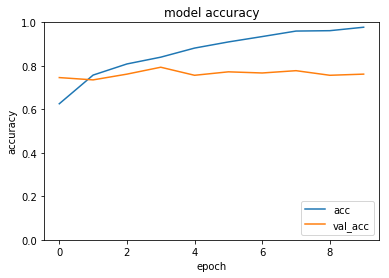

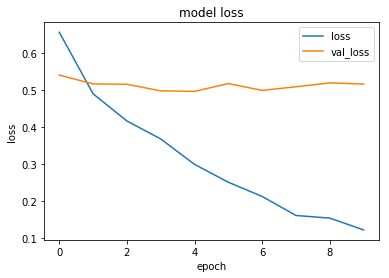

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(history):
    # print(history.history.keys())

    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.ylim(0, 1.0)
    plt.legend(['acc', 'val_acc'], loc='lower right')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['loss', 'val_loss'], loc='upper right')
    plt.show()

plot_history(history)

In [11]:
np.savez('../plots/Bottleneck_features(InceptionV3)_train', acc=history.history['acc'], loss=history.history['loss'])
np.savez('../plots/Bottleneck_features(InceptionV3)_valid', acc=history.history['val_acc'], loss=history.history['val_loss'])